### Boosting

Kearns & Valiant(1989)는 약한 추정기들을 병합해 더 높은 정확도를 얻을 수 있는지의 의문을 제기한 최초의 사람들에 속한다. 그 후 Schapire(1990)는 통상 Boosting이라 부르는 방법을 사용에 질문에 대한 답이 양성적이라는 것을 증명했다. Boosting은 일반적으로 다음과 같이 작동한다.

1. 어떤 샘플 가중치에 따라 복원 랜덤 샘플링을 활용해 하나의 훈련셋을 생성한다
2. 하나의 추정기를 이 훈련 데이터셋을 사용해 적합화한다
3. 단일 추정기가 허용 임계값보다 높은 정확도를 얻으면 그 추정기는 유지하고, 그렇지 않으면 폐기한다
4. 잘못 분류된 관측값에는 더 많은 가중치를 부여하고, 정확히 분류된 가중치에는 더 적은 가중치를 부여한다.
5. N개의 추정기가 생성될 때까지 이 과정을 반복한다.
6. Ensemble 예측은 N 모델에서 나온 개별 예측의 가중 평균인데 가중치는 개별 추정기의 정확도에 따라서 결정된다

Boosting 알고리즘에는 종류가 굉장히 많으며, 대표적으로 다음과 같은 Boosting 모형이 사용된다

|       계열        |       Model       | Description                                                               |
|:---------------:|:-----------------:|:--------------------------------------------------------------------------|
| Adaptive method |   Ada Boosting    | 여러 약한 학습기를 순차적으로 훈련시킴. 각각의 학습기가 틀린 데이터 포인트에 가중치를 부여하여 다음 학습기가 더 잘 학습하도록 함 |
| Adaptive method |       SAMME       | AdaBoost의 이진 분류 문제를 다중 클래스에 대한 분류 문제로 확장한 모형                              |
| Adaptive method |    Brown Boost    | 데이터의 노이즈에 민감한 문제를 다루기 위해 설계된 AdaBoost 변형, 학습 과정에서 노이즈를 억제하는 특성이 있음        |
| Gradient method | Gradient Boosting | 오차에 가중치를 더하고 학습시키는 과정에서 경사 하강법을 사용하여 손실 함수를 최소화하는 방향으로 진행                 |
| Gradient method |     XG Boost      | Gradient Boosting과 같은 방식이지만, GPU 가속이 가능하려 빠른 병렬처리가 가능                     |
| Gradient method |     Light GBM     | Level wise 방법이 아닌 leaf wise 방법을 사용해 XG Boost의 속도를 개선                      |
| Gradient method |     CatBoost      | Level wise 방법 사용, 오차를 줄이는 방법에서 전체 오차가 아닌 부분 오차를 줄이는 것을 목적으로 overfit을 개선   |

### 금융에 있어서의 Bagging vs. Boosting

앞서 설명한 것처럼 부스팅은 몇 가지 측면에서 배깅과 상당히 다르다.

- 개별 분류기가 순차적으로 적합화된다
- 성능이 나쁜 분류기는 퇴출된다
- 관측값의 가중치를 각 반복 시행마다 다르게 부여한다
- Ensemble 예측은 개별 학습기의 가중 평균이다

부스팅의 주요 장점은 예측의 분산과 편향을 둘 다 감소시킨다는 것이다. 그러나 편향을 교정하면 과적합이 될 위험성이 커진다. 금융에 있어서는 부스팅보다 배깅이 일반적으로 더 선호된다고 주장할 수 있다. 배깅은 과대적합, 부스팅은 과소적합을 다룬다. 과대적합은 종종 과소적합보다 더 문제가 된다. 그 이유는, 금융 데이터에 있어서 머신러닝 알고리즘을 과대적합 하는것은 낮은 신호 대 잡음 비율로 인해 그리 어려운 일이 아니기 때문이다. 게다가 배깅은 병렬 처리가 가능하지만, 일반적으로 부스팅은 순차적으로 수행해야 한다.

#### Example : Random Forest vs. CatBoosting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from FinancialMachineLearning.labeling.labeling import *

triple_barrier_event = pd.read_parquet('../../../Data/AAPL_triple_barrier_events.parquet')
avg_uniqueness = pd.read_parquet('../../../Data/AAPL_avg_unique.parquet')
feature_matrix = pd.read_parquet('../../../Data/AAPL_feature_matrix.parquet')

labels = meta_labeling(
    triple_barrier_event, 
    feature_matrix['Close']
)
triple_barrier_event['side'] = labels['bin']
meta_labels = meta_labeling(
    triple_barrier_event, # with side labels
    feature_matrix['Close']
)

feature_matrix['side'] = triple_barrier_event['side'].copy()
feature_matrix['label'] = meta_labels['bin'].copy()
feature_matrix.drop(['Open','High','Low','Close','Adj Close','Volume'], axis = 1, inplace = True)
feature_matrix.dropna(inplace = True)

matrix = feature_matrix[feature_matrix['side'] != 0]
X = matrix.drop(['side','label'], axis = 1)
y = matrix['label']

X_train, X_test = X.loc[:'2019'], X.loc['2020':]
y_train, y_test = y.loc[:'2019'], y.loc['2020':]

**Random Forest**

Sequential Bootstrapping을 위해서 다음과 같이 Random Forest Classifier를 상속받아 새로운 클래스 `SequentialRandomForestClassifier`를 정의한다

In [2]:
from sklearn.ensemble import RandomForestClassifier
from FinancialMachineLearning.sample_weights.bootstrapping import *

class SequentialRandomForestClassifier(RandomForestClassifier):
    def _generate_sample_indices(self, random_state, n_samples):
        """Generate bootstrap sample indices with sequential bootstrap method."""
        random_instance = random_state  # get the RandomState instance
        
        ind_mat = get_indicator_matrix(
            triple_barrier_event.index.to_series(),
            triple_barrier_event['t1']
        )
        
        sample_indices = seq_bootstrap(ind_mat, n_samples)
        
        return sample_indices

In [3]:
forest = SequentialRandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    random_state = 42,
    n_estimators = 100,
    max_features = 3, # early stopping
    min_weight_fraction_leaf = 0.05, # early stopping
    oob_score = True
)

forest_fit = forest.fit(
    X = X_train, 
    y = y_train, 
    sample_weight = avg_uniqueness.loc[X_train.index].to_numpy().reshape(1, -1)[0]
)

In [4]:
forest_fit.oob_score_

0.8315755832534356

In [5]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

y_prob = forest_fit.predict_proba(X_test)[:, 1]
y_pred = forest_fit.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8655126498002663


In [6]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.12      0.07      0.09        70
         1.0       0.91      0.95      0.93       681

    accuracy                           0.87       751
   macro avg       0.52      0.51      0.51       751
weighted avg       0.84      0.87      0.85       751



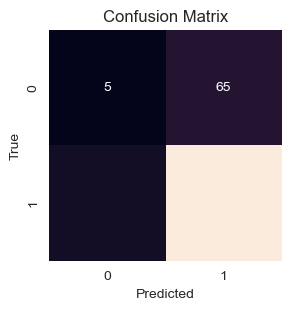

In [7]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (3, 3))
sns.heatmap(cm, annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

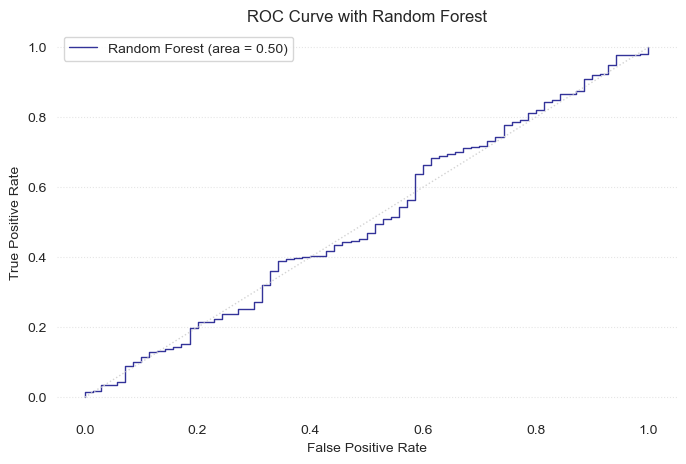

In [8]:
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(fpr, tpr, label = 'Random Forest (area = {:.2f})'.format(roc_auc), color = 'navy', alpha = 0.8, lw = 1)
ax.plot([0, 1], [0, 1], color = 'lightgray', ls = ':', lw = 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Random Forest')

for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
ax.legend()

plt.show()

**Cat Boosting**

In [9]:
from catboost import CatBoostClassifier, Pool

cat_boost = CatBoostClassifier(
    iterations = 1000,
    learning_rate = 0.1,
    depth = 3,
    random_seed = 42,
    class_weights = [1, 1],
    custom_metric = ['AUC', 'Accuracy'],
    verbose = False
)

cat_boost_fit = cat_boost.fit(
    X = X_train, 
    y = y_train, 
    sample_weight = avg_uniqueness.loc[X_train.index].to_numpy().reshape(1, -1)[0]
)

In [10]:
y_prob = cat_boost_fit.predict_proba(X_test)[:, 1]
y_pred = cat_boost_fit.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9067909454061251


In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        70
         1.0       0.91      1.00      0.95       681

    accuracy                           0.91       751
   macro avg       0.45      0.50      0.48       751
weighted avg       0.82      0.91      0.86       751



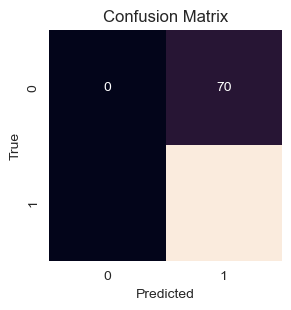

In [12]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (3, 3))
sns.heatmap(cm, annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

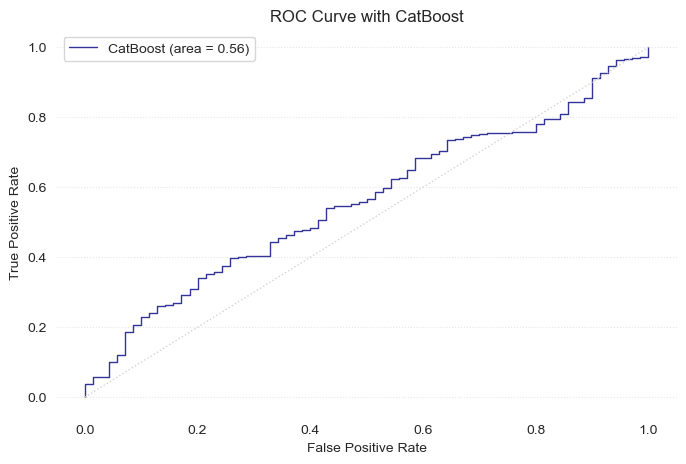

In [13]:
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(fpr, tpr, label = 'CatBoost (area = {:.2f})'.format(roc_auc), color = 'navy', alpha = 0.8, lw = 1)
ax.plot([0, 1], [0, 1], color = 'lightgray', ls = ':', lw = 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with CatBoost')

for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
ax.legend()

plt.show()